In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

df_med = pd.read_csv('Medical_Data_Set/medical_clean.csv')
original_df_med = pd.read_csv('Medical_Data_Set/medical_clean.csv')
pd.set_option('display.max_columns', None)

# When True, displays extensive summary statistics and plots. Output streamlined when False.
run_verbose = False

all_columns = ['CaseOrder', 'Customer_id', 'Interaction', 'UID', 'City', 'State',
               'County', 'Zip', 'Lat', 'Lng', 'Population', 'Area', 'TimeZone', 'Job',
               'Children', 'Age', 'Income', 'Marital', 'Gender', 'ReAdmis',
               'VitD_levels', 'Doc_visits', 'Full_meals_eaten', 'vitD_supp',
               'Soft_drink', 'Initial_admin', 'HighBlood', 'Stroke',
               'Complication_risk', 'Overweight', 'Arthritis', 'Diabetes',
               'Hyperlipidemia', 'BackPain', 'Anxiety', 'Allergic_rhinitis',
               'Reflux_esophagitis', 'Asthma', 'Services', 'Initial_days',
               'TotalCharge', 'Additional_charges', 'Item1', 'Item2', 'Item3', 'Item4',
               'Item5', 'Item6', 'Item7', 'Item8']

identifier_cat_columns = ['CaseOrder', 'Customer_id', 'Interaction', 'UID']

large_cat_columns = ['City', 'County', 'Zip', 'Job']

small_cat_columns = ['State', 'Area', 'TimeZone', 'Marital', 'Gender', 'Initial_admin', 'Complication_risk', 'Services']

yes_no_columns = ['ReAdmis', 'Soft_drink', 'HighBlood', 'Stroke', 'Overweight', 'Arthritis', 'Diabetes',
                  'Hyperlipidemia', 'BackPain', 'Anxiety', 'Allergic_rhinitis', 'Reflux_esophagitis', 'Asthma']

item1_to_8_columns = ['Item1', 'Item2', 'Item3', 'Item4', 'Item5', 'Item6', 'Item7', 'Item8']

small_int_columns = ['Children', 'Age', 'Doc_visits', 'Full_meals_eaten', 'vitD_supp']

continuous_columns = ['Lat', 'Lng', 'Population', 'Income', 'VitD_levels', 'Initial_days', 'TotalCharge',
                      'Additional_charges']

In [2]:
# Creates a new column 'Zip_int64' to back up the old 'Zip' values while adjusting current 'Zip' values to strings with
# five digits.
def zip_to_str(zip_col='Zip', df=df_med):
    df['Zip_int64'] = df[zip_col]
    df[zip_col] = df[zip_col].astype('str')
    for i in range(5):
        df[zip_col].mask(df[zip_col].str.len() == i, '0' * (5 - i) + df[zip_col], inplace=True)
    print(
        f"Verifying number of entries in 'Zip' with number of digits other than 5: {len(df.loc[df['Zip'].str.len() != 5, 'Zip'])}\n")
    print(
        f"Verifying number of entries in 'Zip' with number of digits exactly 5: {len(df.loc[df['Zip'].str.len() == 5, 'Zip'])}\n")


# Changing 'CaseOrder' and 'Zip' to strings, also verifying there are no duplicates or nulls
df_med['CaseOrder'] = df_med['CaseOrder'].astype('str')
zip_to_str()
print(f"Checking for columns with null values: {list(df_med.columns[df_med.isna().sum() > 0])}\n")
print("Verifying there are no duplicate entries ('False' indicates not a duplicate):")
print(df_med.duplicated(keep=False).value_counts())
print("\n")


# Dataframe description and value counts
def inspect_data(columns, df=df_med):
    for col in columns:
        if (df[col].dtype == 'int64') or (df[col].dtype == 'float64'):
            print(f"\nNumber of unique values: {len(df[col].unique())}")
            print(df[col].describe())
        else:
            print(df[col].describe())
            print(df[col].value_counts())
            print("\n")


# Searches for outliers by IQR and z-scores (defaults to |z| > 3.0) with optional z-score histogram plot
def outlier_search(columns, plots=True, z_bound=3.0, df=df_med):
    df_outliers_dict = {}
    df_zscore_outl_dict = {}
    for column in columns:
        col_stats = df[column].describe()
        q25 = col_stats['25%']
        q75 = col_stats['75%']
        lower_bound = q25 - 1.5 * (q75 - q25)
        upper_bound = q75 + 1.5 * (q75 - q25)
        df_outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        col_zscore = column + '_zscore'
        with pd.option_context("mode.chained_assignment", None):
            df_outliers[col_zscore] = stats.zscore(df[column])
        df_zscore = pd.DataFrame(stats.zscore(df[column]))
        df_zscore_outl = df_zscore[abs(df_zscore[column]) > z_bound]
        print("----------------------")
        print(f"{column}:")
        print(col_stats)
        print("\nZ-scores:")
        print(df_zscore.describe())
        print(f"\nIQR test for outliers has a lower bound of {round(lower_bound, 3)} and an upper bound"
              f" of {round(upper_bound, 3)}")
        print(f"Z-scores have a lower bound of {-1 * z_bound} and an upper bound of {z_bound}\n")
        if df_outliers.empty and df_zscore.empty:
            print(f"There are no outliers in the column {column}.")
        else:
            print(f"By IQR, there are {len(df_outliers)} outliers.")
            print(df_outliers[[column, col_zscore]])
            print(f"\nBy z-score, there are {len(df_zscore_outl)} outliers.")
            print(df_zscore_outl)
        df_outliers_dict[column] = df_outliers
        df_zscore_outl_dict[column] = df_zscore_outl
        if plots:
            plt.hist(df_zscore)
            plt.xlabel(column + ' z-score')
            plt.ylabel('Frequency')
            plt.show()
        print("----------------------\n")
    return df_outliers_dict, df_zscore_outl_dict

Verifying number of entries in 'Zip' with number of digits other than 5: 0

Verifying number of entries in 'Zip' with number of digits exactly 5: 10000

Checking for columns with null values: []

Verifying there are no duplicate entries ('False' indicates not a duplicate):
False    10000
Name: count, dtype: int64




In [4]:
relevant_columns = ['ReAdmis', 'Initial_days', 'Children', 'Age', 'Population', 'Lat', 'Additional_charges', 'Complication_risk',
                    'Initial_admin', 'BackPain', 'Arthritis', 'Anxiety', 'Asthma', 'Hyperlipidemia', 'Stroke',
                    'Overweight', 'Services']
inspect_data(df_med[relevant_columns])

count     10000
unique        2
top          No
freq       6331
Name: ReAdmis, dtype: object
ReAdmis
No     6331
Yes    3669
Name: count, dtype: int64



Number of unique values: 9997
count    10000.000000
mean        34.455299
std         26.309341
min          1.001981
25%          7.896215
50%         35.836244
75%         61.161020
max         71.981490
Name: Initial_days, dtype: float64

Number of unique values: 11
count    10000.000000
mean         2.097200
std          2.163659
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max         10.000000
Name: Children, dtype: float64

Number of unique values: 72
count    10000.000000
mean        53.511700
std         20.638538
min         18.000000
25%         36.000000
50%         53.000000
75%         71.000000
max         89.000000
Name: Age, dtype: float64

Number of unique values: 5951
count     10000.000000
mean       9965.253800
std       14824.758614
min           0.000000
25%         694

In [ ]:
inspect_data(df_med.columns)
outlier_search(small_int_columns)
outlier_search(continuous_columns)
outlier_search(item1_to_8_columns)

In [5]:
global_encoded_columns = []
# one hot encoding that maintains a list of encoded columns in global_encoded_columns
def one_hot_encoder(columns, df=df_med):
    for column in columns:
        df_one_hot_col = pd.get_dummies(df[column], drop_first=True).astype('int32')
        for col in df_one_hot_col.columns:
            col_name = f'{column}_' + col
            if col_name not in global_encoded_columns:
                global_encoded_columns.append(col_name)
                df[col_name] = df_one_hot_col[col]


# 'Marital', 'TimeZone', and 'State' were found to have very low coefficients, but are not depicted due to the
# large number of additional columns they created. The remaining categorical variables are to be one hot encoded.
columns_to_encode = ['Area', 'Gender', 'Initial_admin', 'Complication_risk', 'Services',
                     'ReAdmis', 'Soft_drink', 'HighBlood', 'Stroke', 'Overweight', 'Arthritis', 'Diabetes',
                     'Hyperlipidemia', 'BackPain', 'Anxiety', 'Allergic_rhinitis', 'Reflux_esophagitis', 'Asthma']
one_hot_encoder(columns_to_encode)
print("Verifying appended columns in dataframe:")
print(df_med.columns)
print("\nVerifying new columns have expected values:")
print(df_med['Diabetes_Yes'].value_counts())
print(df_med['Initial_admin_Emergency Admission'].value_counts())
print(f"\nColumns encoded: {global_encoded_columns}\n")


# Prints correlation matrix values restricted to a specific variable ('column') sorted in descending order of their
# absolute value. Optional threshold parameter 'thresh' defaults to -1.0 and restricts correlated variables to
# those above it.
def corr_search(column, thresh=-1.0, df=df_med):
    sorted_corr = df.select_dtypes(exclude=['object']).corr()[column].sort_values(ascending=False, key=lambda x: abs(x))
    print(sorted_corr[abs(sorted_corr) >= thresh])
    print("\n")


# Setting dependent variable for correlation search, displaying the strongest correlations on 'ReAdmis_Yes'
# corr_search on 'Initial_days' and subsequent variables is done after inspecting a heatmap
dep_var_str = 'ReAdmis'
dep_var = dep_var_str + '_Yes'
corr_search(dep_var)
corr_search('Initial_days', 0.03)
corr_search('Additional_charges', 0.03)
print(df_med.select_dtypes(exclude=['object']).corr()[dep_var].sort_values(ascending=False, key=lambda x: abs(x)).index[1:19])

Verifying appended columns in dataframe:
Index(['CaseOrder', 'Customer_id', 'Interaction', 'UID', 'City', 'State',
       'County', 'Zip', 'Lat', 'Lng', 'Population', 'Area', 'TimeZone', 'Job',
       'Children', 'Age', 'Income', 'Marital', 'Gender', 'ReAdmis',
       'VitD_levels', 'Doc_visits', 'Full_meals_eaten', 'vitD_supp',
       'Soft_drink', 'Initial_admin', 'HighBlood', 'Stroke',
       'Complication_risk', 'Overweight', 'Arthritis', 'Diabetes',
       'Hyperlipidemia', 'BackPain', 'Anxiety', 'Allergic_rhinitis',
       'Reflux_esophagitis', 'Asthma', 'Services', 'Initial_days',
       'TotalCharge', 'Additional_charges', 'Item1', 'Item2', 'Item3', 'Item4',
       'Item5', 'Item6', 'Item7', 'Item8', 'Zip_int64', 'Area_Suburban',
       'Area_Urban', 'Gender_Male', 'Gender_Nonbinary',
       'Initial_admin_Emergency Admission',
       'Initial_admin_Observation Admission', 'Complication_risk_Low',
       'Complication_risk_Medium', 'Services_CT Scan', 'Services_Intravenous',
  

In [6]:
def univariate_plots(columns, df=df_med):
    for column in columns:
        plt.hist(df[column])
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.title(f"Histogram of {column}")
        plt.show()


def bivariate_plots(columns, target_column=dep_var_str, df=df_med):
    for column in columns:
        plt.xlabel(column)
        plt.ylabel('Frequency')
        if ((df[column].dtype == 'float64') or
                ((df[column].dtype == 'int64') and (df[column].max() - df[column].min() > 10))):
            sns.kdeplot(data=df, x=column, hue=target_column)
            plt.title(f"Bivariate density plot of {column} grouped by {target_column}")
        else:
            sns.countplot(data=df, x=column, hue=target_column)
            plt.title(f"Bivariate histogram of {column} grouped by {target_column}")
        plt.show()

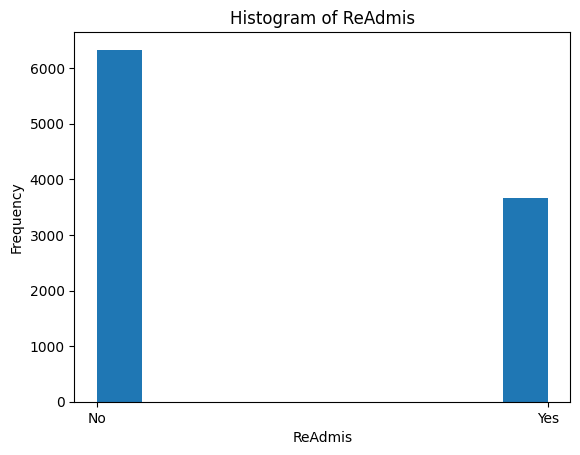

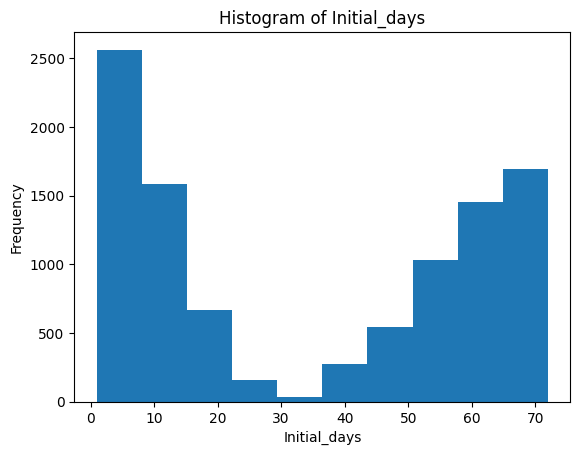

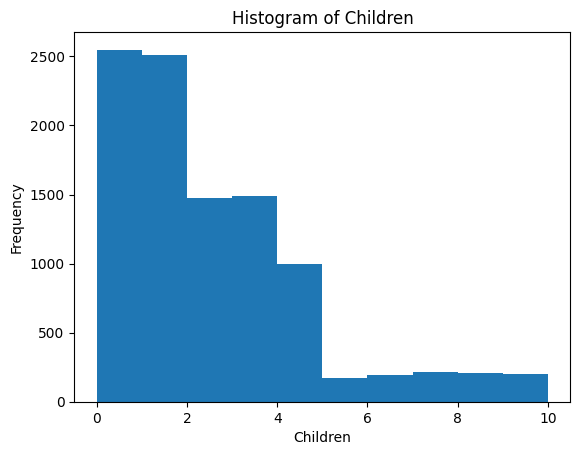

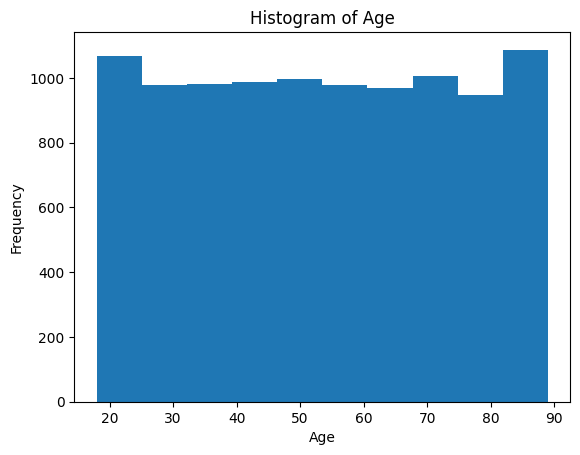

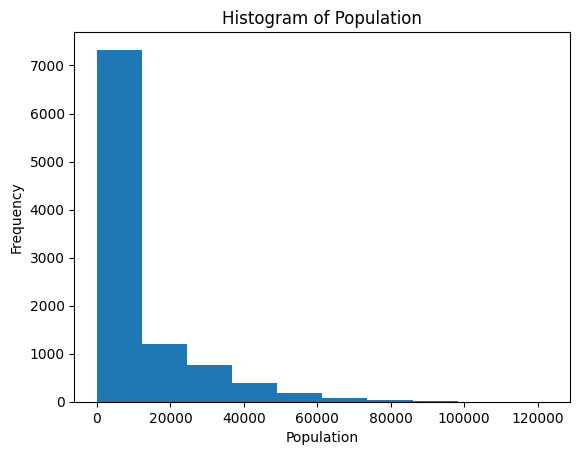

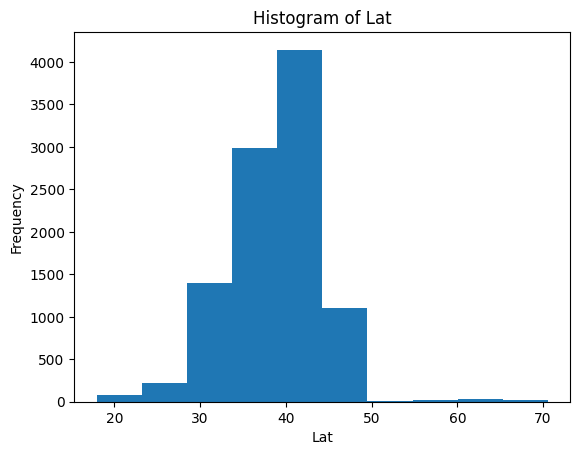

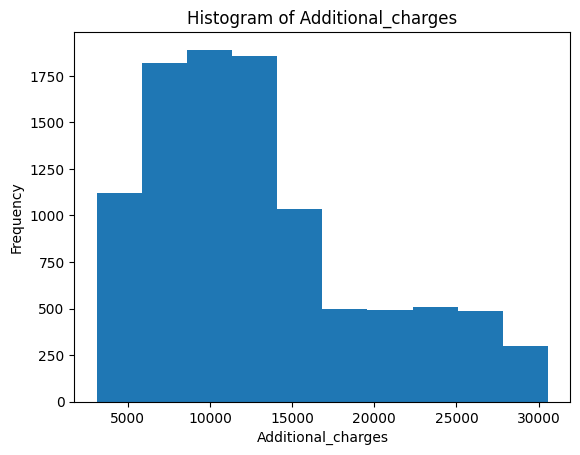

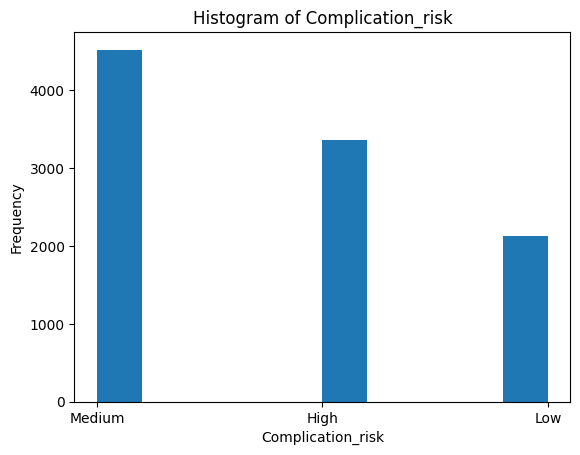

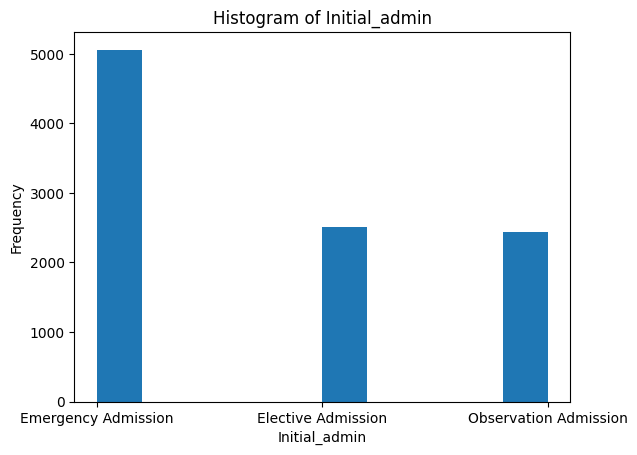

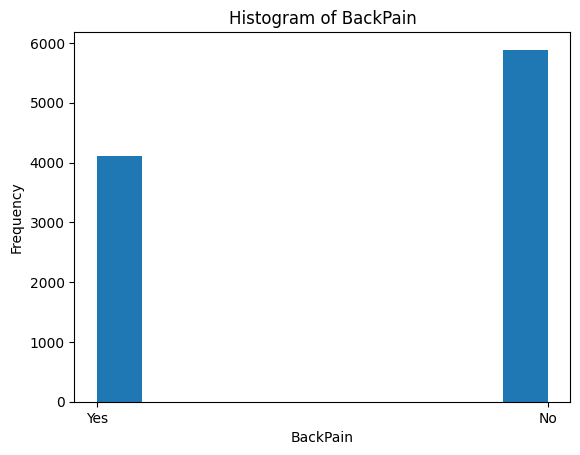

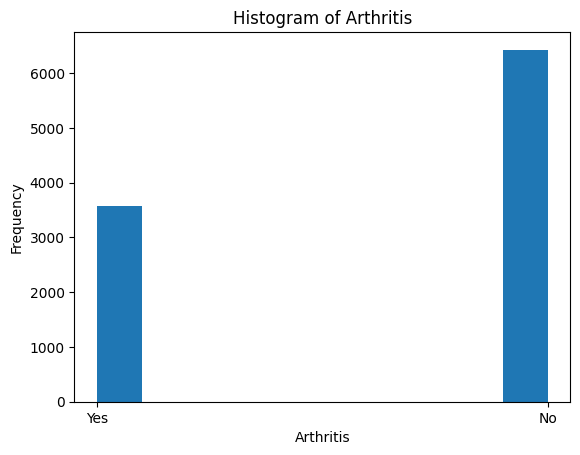

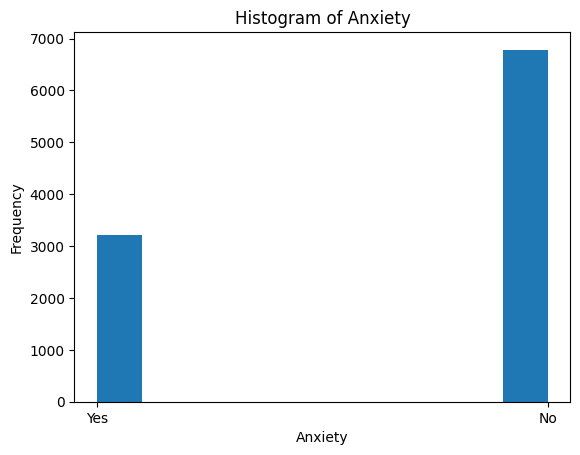

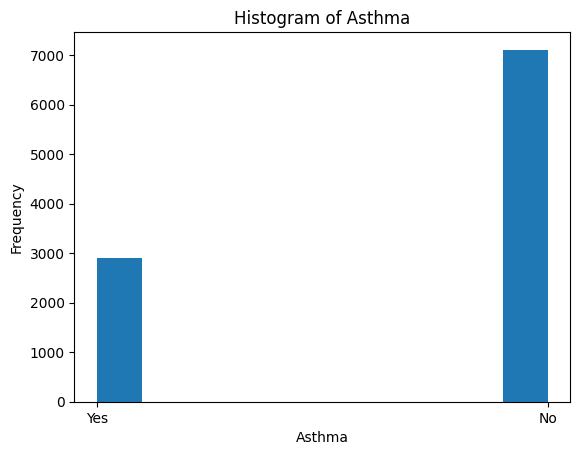

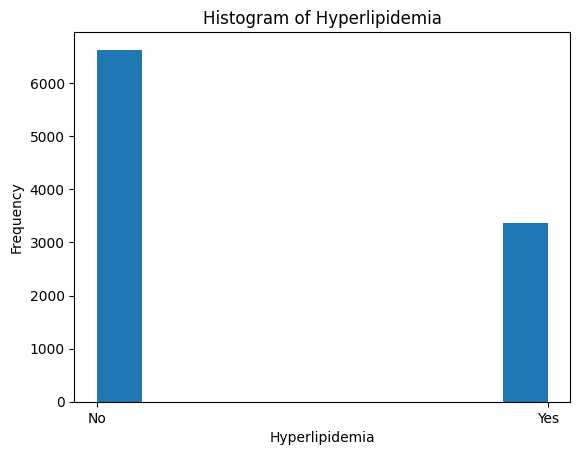

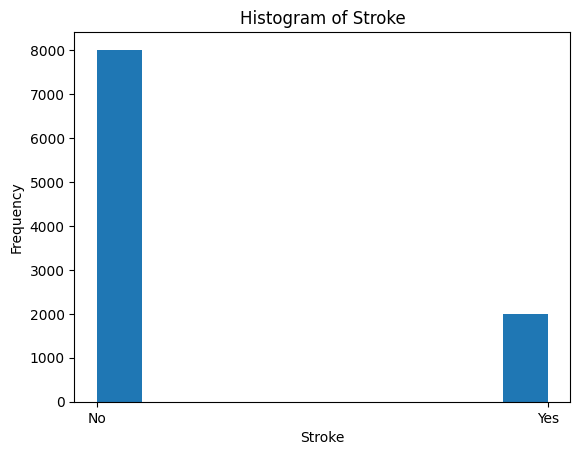

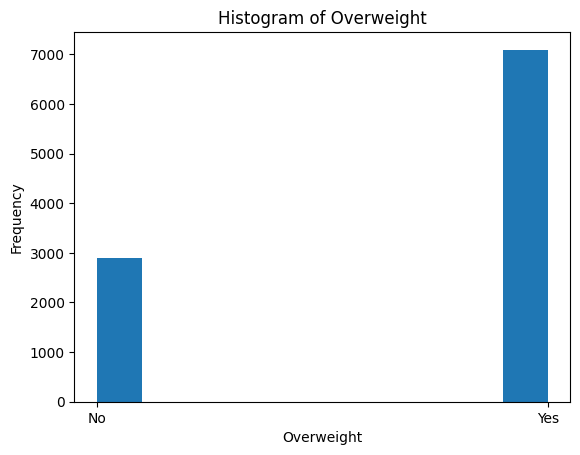

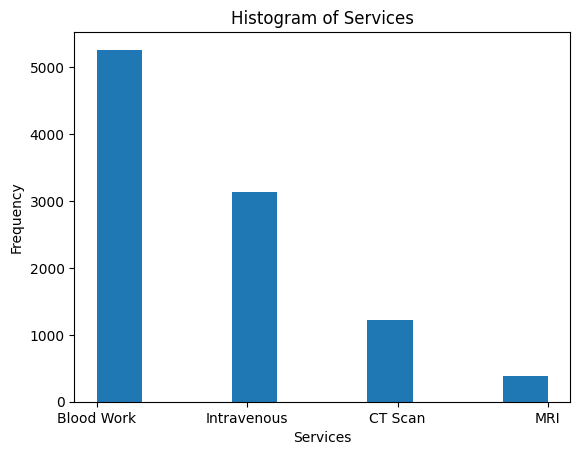

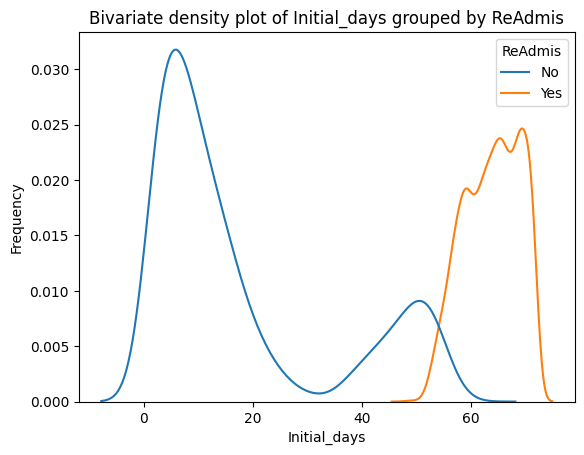

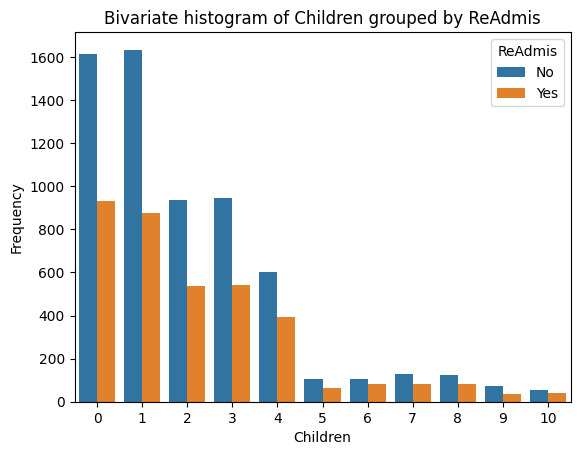

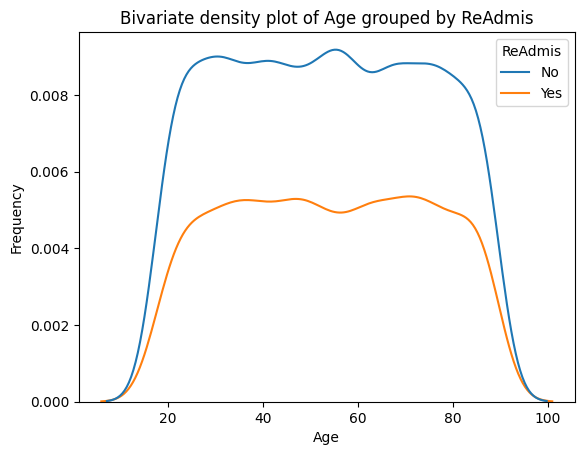

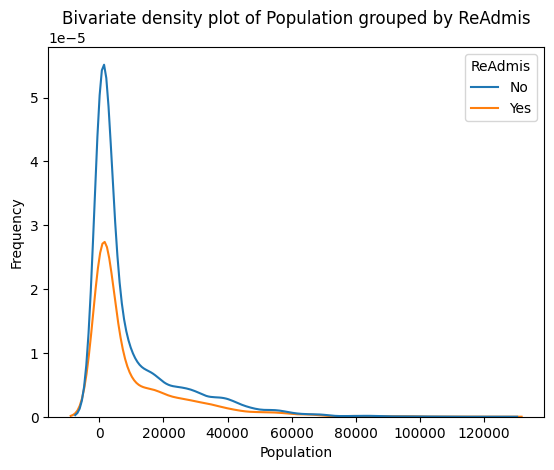

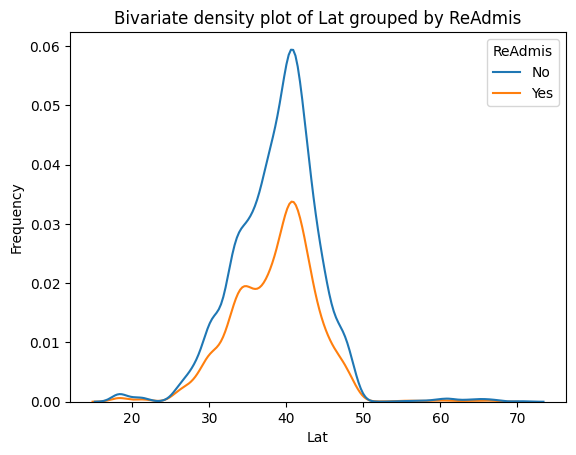

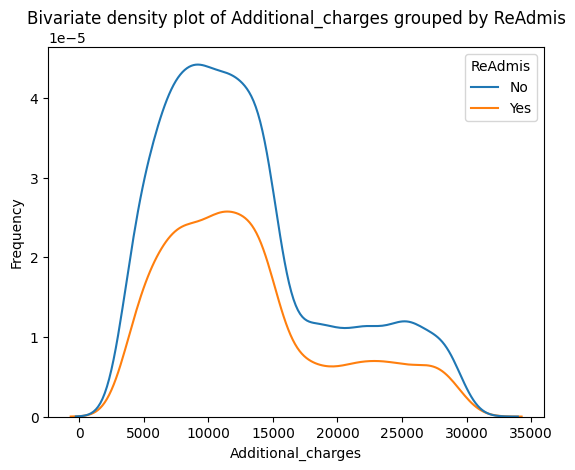

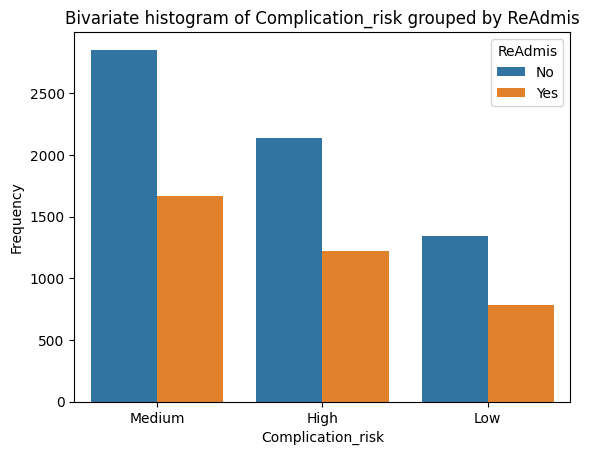

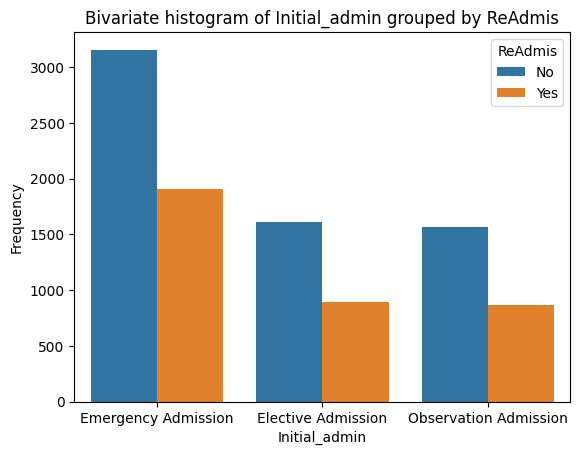

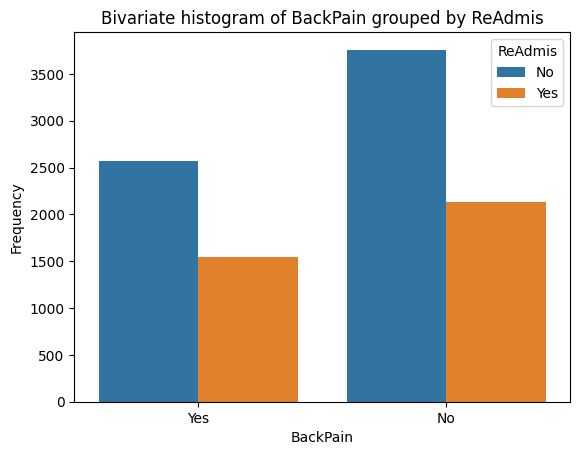

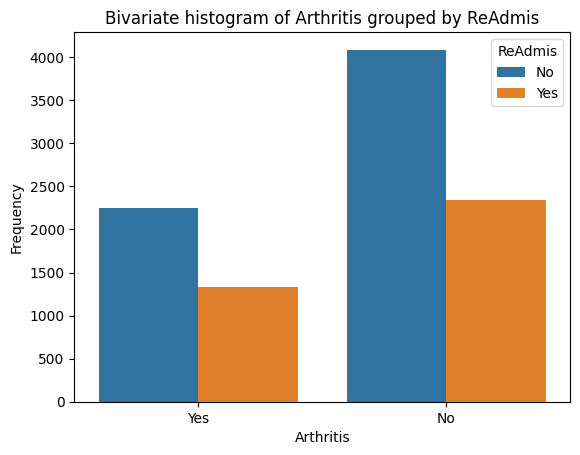

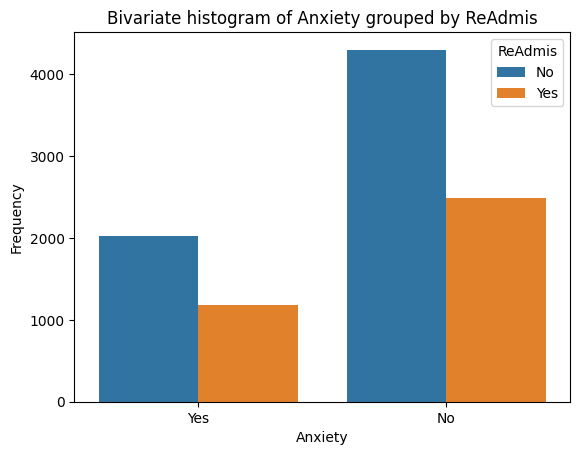

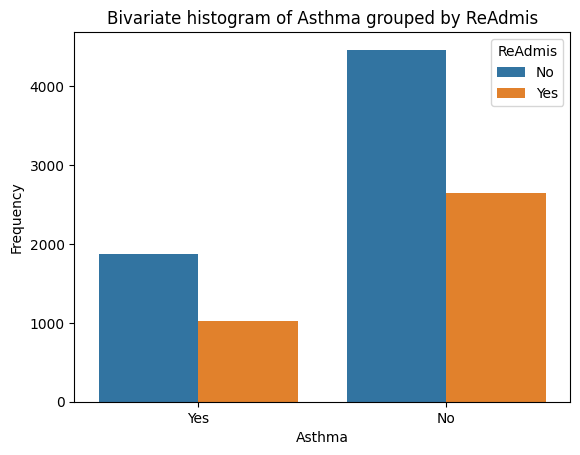

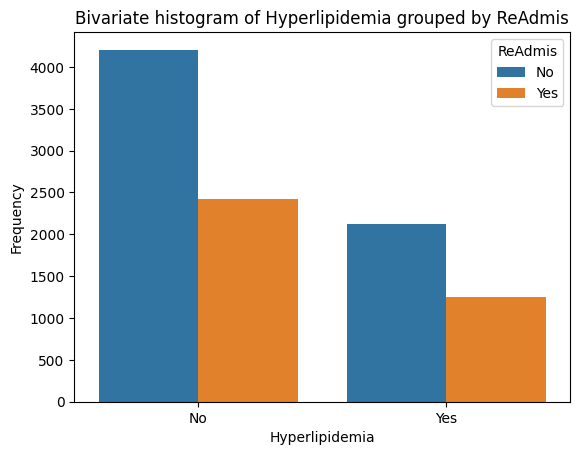

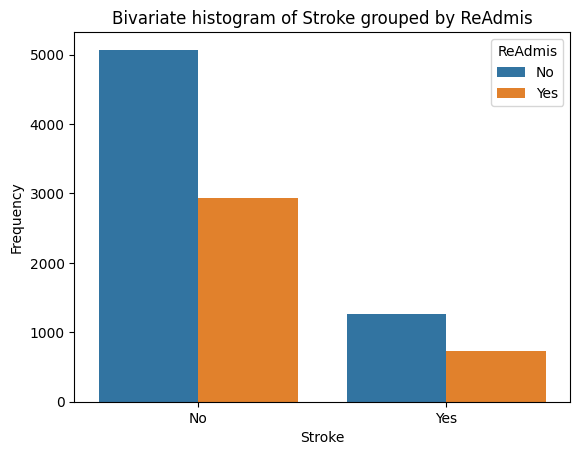

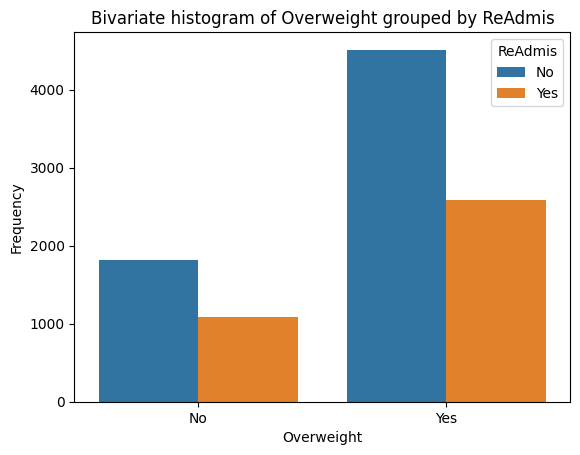

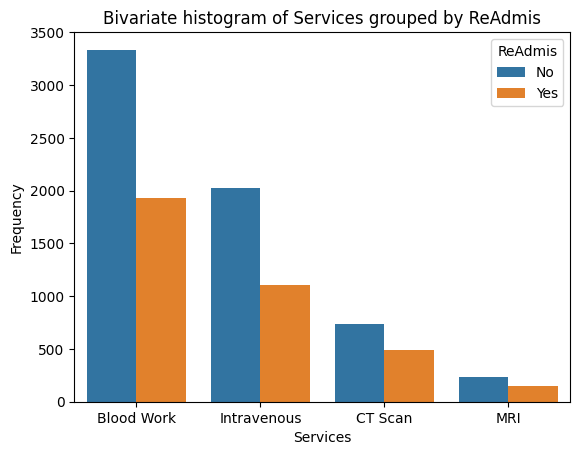

In [7]:
plot_columns = ['Initial_days', 'Children', 'Age', 'Population', 'Lat', 'Additional_charges', 'Complication_risk',
                'Initial_admin', 'BackPain', 'Arthritis', 'Anxiety', 'Asthma', 'Hyperlipidemia', 'Stroke',
                'Overweight', 'Services']

print("")
univariate_plots([dep_var_str] + plot_columns)
bivariate_plots(plot_columns)

In [8]:
# Manually creating 'Complication_risk_High' column as the Medium and Low values were correlated and produced inferior
# model results. Creating a vector of 1s for a constant term.
df_med['Complication_risk_High'] = 1 - df_med['Complication_risk_Medium'] - df_med['Complication_risk_Low']
df_med['model_constant'] = 1
df_med.to_csv(r'Medical_Data_Set/medical_transformed_logistic.csv')

# Initial model independent variables
model_indp_var = ['model_constant', 'Initial_days', 'Children', 'Age', 'Population', 'Lat', 'Additional_charges',
                  'Complication_risk_High', 'Initial_admin_Emergency Admission', 'BackPain_Yes', 'Arthritis_Yes',
                  'Anxiety_Yes', 'Asthma_Yes', 'Hyperlipidemia_Yes', 'Stroke_Yes', 'Overweight_Yes', 'Services_MRI',
                  'Services_CT Scan']
model_dep_var = 'ReAdmis_Yes'
X_0 = df_med[model_indp_var]
y_0 = df_med[model_dep_var]


# Logistic regression model for target y ('ReAdmis_Yes' in this case) with independent variables X (see model_indp_var)
def log_model(y, X):
    model = sm.Logit(y, X)
    results = model.fit()
    print(results.summary())
    print(f"\nAIC: {2 * (2 + results.df_model) - 2 * results.llf}")
    print(f"Predicted percentage of readmissions: "
          f"{np.round(results.predict()[results.predict() >= 0.5].sum() / len(results.predict()), 4)}")
    print(f"Accuracy: {accuracy_score(y, np.round(results.predict()))}\n")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)
    model_sk = LogisticRegression(C=1.0, class_weight='balanced', max_iter=200, penalty='l1', solver='liblinear', random_state=5)
    model_sk.fit(X_train, y_train)
    print(f"Coefficients: {dict(zip(X.columns, model_sk.coef_[0]))}\n")
    y_pred = model_sk.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred)
    validation = cross_val_score(model_sk, X_train, y_train, cv=8)
    metric_scores = classification_report(y_test, y_pred)
    print(f"Confusion matrix: \n{conf_matrix}\n")
    print(f"Cross validation scores: {validation}\n")
    print(f"Classification report: \n{metric_scores}\n")

    sns.heatmap(X.corr(), annot=True)
    plt.show()

    vif_data = pd.DataFrame({'feature': X.columns, 'VIF': [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]})
    print(vif_data)


# Adapted from DataCamp's "Dimensionality Reduction in Python" ch. 3 (Jeroen Boeye), accessed 2024.
# https://campus.datacamp.com/courses/dimensionality-reduction-in-python/feature-selection-ii-selecting-for-model-accuracy?ex=1
# RFE for reduction of initial model's independent variables
def rfe_review(y, X, features=11):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)
    model_scaler = StandardScaler()
    X_train_scaled = model_scaler.fit_transform(X_train)
    X_test_scaled = model_scaler.fit_transform(X_test)
    rfe = RFE(estimator=LogisticRegression(), n_features_to_select=features)
    rfe.fit(X_train_scaled, y_train)
    print(X.columns[rfe.support_])
    print(dict(zip(X.columns, rfe.ranking_)))
    print(rfe.ranking_)
    print(r2_score(y_test, rfe.predict(X_test_scaled)))
    print(mean_squared_error(y_test, rfe.predict(X_test_scaled)))

Optimization terminated successfully.
         Current function value: 0.035494
         Iterations 14
                           Logit Regression Results                           
Dep. Variable:            ReAdmis_Yes   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9982
Method:                           MLE   Df Model:                           17
Date:                Mon, 22 Apr 2024   Pseudo R-squ.:                  0.9460
Time:                        19:35:31   Log-Likelihood:                -354.94
converged:                       True   LL-Null:                       -6572.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
model_constant                      -76.1188      4.145    -1

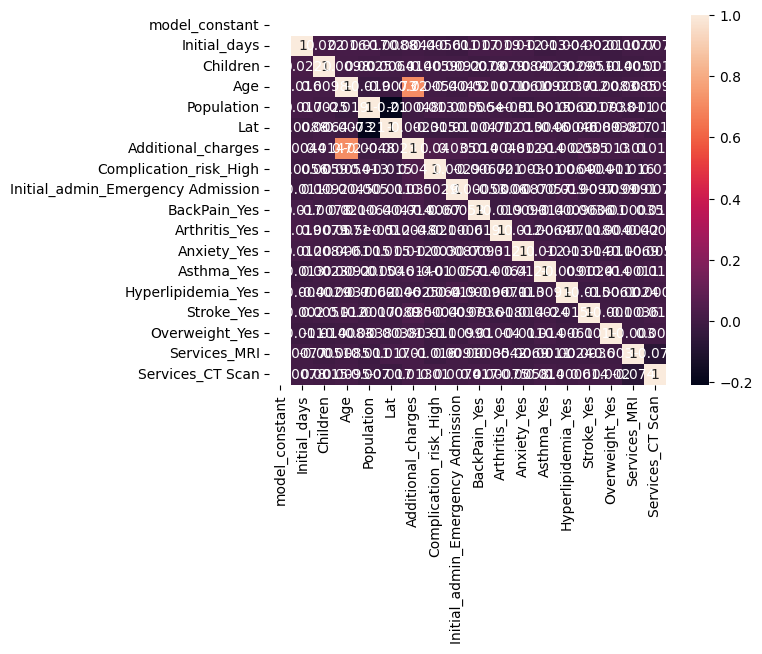

                              feature        VIF
0                      model_constant  74.219217
1                        Initial_days   1.002624
2                            Children   1.001284
3                                 Age   2.068067
4                          Population   1.046554
5                                 Lat   1.046534
6                  Additional_charges   2.075256
7              Complication_risk_High   1.004348
8   Initial_admin_Emergency Admission   1.004243
9                        BackPain_Yes   1.001948
10                      Arthritis_Yes   1.002021
11                        Anxiety_Yes   1.001768
12                         Asthma_Yes   1.001407
13                 Hyperlipidemia_Yes   1.001111
14                         Stroke_Yes   1.002729
15                     Overweight_Yes   1.001887
16                       Services_MRI   1.006566
17                   Services_CT Scan   1.007010
Index(['Initial_days', 'Age', 'Additional_charges', 'Complication_ris

In [9]:
log_model(y_0, X_0)
rfe_review(y_0, X_0)

Optimization terminated successfully.
         Current function value: 0.036090
         Iterations 14
                           Logit Regression Results                           
Dep. Variable:            ReAdmis_Yes   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9988
Method:                           MLE   Df Model:                           11
Date:                Mon, 22 Apr 2024   Pseudo R-squ.:                  0.9451
Time:                        19:37:16   Log-Likelihood:                -360.90
converged:                       True   LL-Null:                       -6572.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
model_constant                      -73.5545      3.881    -1

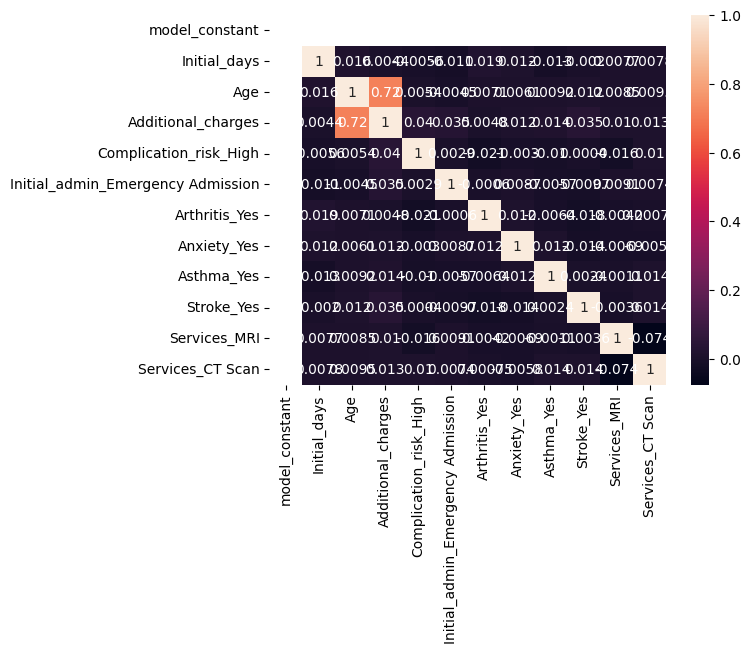

                              feature        VIF
0                      model_constant  12.633555
1                        Initial_days   1.001329
2                                 Age   2.064666
3                  Additional_charges   2.072922
4              Complication_risk_High   1.003743
5   Initial_admin_Emergency Admission   1.003511
6                       Arthritis_Yes   1.001378
7                         Anxiety_Yes   1.000938
8                          Asthma_Yes   1.000931
9                          Stroke_Yes   1.002466
10                       Services_MRI   1.006174
11                   Services_CT Scan   1.006351


In [10]:
# Refined model independent variables
model_indp_var_new = ['model_constant', 'Initial_days', 'Age', 'Additional_charges', 'Complication_risk_High',
                      'Initial_admin_Emergency Admission', 'Arthritis_Yes', 'Anxiety_Yes', 'Asthma_Yes', 'Stroke_Yes',
                      'Services_MRI', 'Services_CT Scan']
model_dep_var_new = 'ReAdmis_Yes'
X_1 = df_med[model_indp_var_new]
y_1 = df_med[model_dep_var_new]


log_model(y_1, X_1)